# Projeto 1 - Modelo de Classificação

### Projeto realizado por :

#### 
* Cosmin Trandafir - 57101
* Martim Baptista - 56323
* João Serafim - 56376
* Martim Paraíba - 56273
***

#### Counter de horas I guess :{}

* Cosmin Trandafir - 4h
* Martim Baptista - 
* João Serafim - 3h
* Martim Paraíba - 
***

Questoes: 
- Devemos apagar colunas que possuem demasiados valores a zero?
- Devemos normalizar primeiro ou inputar primeiro?
- Devemos testar e mostrar os testes de todos os hyperparametros ou apenas os principais?

- Devemos testar com IterativeImputer?

### Neste projeto vamos usar o dataset: ***biodegradable_a.cvs*** 

In [72]:
import pandas as pd

#Load biodegradable dataset

bio_df = pd.read_csv("biodegradable_a.csv")
bio_df

,SpMax_L,J_Dz(e),nHM,F01,F04,NssssC,nCb,C,nCp,nO,...,C_026,F02_CN,nHDon,SpMax_B,Psi_i_A,nN,SM6_B,nArCOOR,nX,Biodegradable
0,3.919000,2.690900,0.0,0.0,0.0,0.0,0.0,31.400000,2.0,0.0,...,0.0,0.0,0.0,2.949000,1.591000,0.0,7.253000,0.0,0.0,RB
1,4.170000,2.114400,0.0,0.0,0.0,0.0,0.0,30.800000,1.0,1.0,...,0.0,0.0,0.0,3.315000,1.967000,0.0,7.257000,0.0,0.0,RB
2,3.932000,3.251200,0.0,0.0,0.0,0.0,0.0,26.700000,2.0,4.0,...,0.0,0.0,1.0,NaN,2.417000,0.0,7.601000,0.0,0.0,RB
3,3.000000,2.709800,0.0,0.0,0.0,0.0,0.0,20.000000,NaN,2.0,...,0.0,0.0,1.0,NaN,5.000000,0.0,6.690000,0.0,0.0,RB
4,4.236000,3.394400,0.0,0.0,0.0,0.0,0.0,29.400000,2.0,4.0,...,0.0,0.0,0.0,3.351000,2.405000,0.0,8.003000,0.0,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4559,4.175650,3.454649,0.0,0.0,0.0,0.0,0.0,27.300000,2.0,2.0,...,0.0,0.0,0.0,3.398382,3.241090,0.0,7.406748,0.0,0.0,RB
4560,3.853731,2.747142,0.0,NaN,0.0,0.0,0.0,33.300000,0.0,0.0,...,0.0,0.0,1.0,3.429148,2.719309,0.0,7.511511,0.0,0.0,RB
4561,4.294771,3.471226,0.0,0.0,0.0,0.0,0.0,28.422154,2.0,2.0,...,0.0,0.0,0.0,3.351666,2.729456,0.0,7.699324,0.0,0.0,RB
4562,4.560376,3.896390,0.0,0.0,0.0,0.0,0.0,NaN,2.0,3.0,...,0.0,0.0,0.0,NaN,3.059198,0.0,7.908802,0.0,0.0,RB


## Generic functions and Imports

In [73]:
from sklearn import impute
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [74]:
def classification_scores(y_test, y_pred):
    # Evaluate the performance of the model using various metrics
    print("The Precision is: %7.4f" % precision_score(y_test, y_pred))
    print("The Recall is: %7.4f" % recall_score(y_test, y_pred))
    print("The F1 score is: %7.4f" % f1_score(y_test, y_pred))
    print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate_model(imputer, scaler, classifier, X_train, X_test, y_train):
    # Impute missing values
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    
    # Scale the test data
    scaler.fit(X_train_imputed)
    X_train_scaled = scaler.transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Train the classifier
    classifier.fit(X_train_scaled, y_train)
    preds = classifier.predict(X_test_scaled)
    
    # Compute evaluation metrics
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    mcc = matthews_corrcoef(y_test, preds)
    
    # Compute cross-validation scores
    cv_scores = cross_val_score(classifier, X_test_scaled, y_test, cv=10)
    mean_cv_score = cv_scores.mean()
    
    # Create histogram
    labels = ['Precision', 'Recall', 'F1 Score', 'MCC', 'Mean CV Score']
    scores = [precision, recall, f1, mcc, mean_cv_score]
    plt.bar(labels, scores)
    plt.title('Model Evaluation Metrics')
    plt.ylim([0.7, 1.0])
    plt.grid(axis='y')
    plt.show()


## Inicialization 

In [80]:
# Divide Freatures and Class columns for preprocessing
X = bio_df.iloc[:, :-1]
y = bio_df.iloc[:, -1]

# Encode string classes to a numeric value for Imputer
le = preprocessing.LabelEncoder()
df_encoded_classes = le.fit_transform(y)

## Data Imputation


***
### Simple Imputer

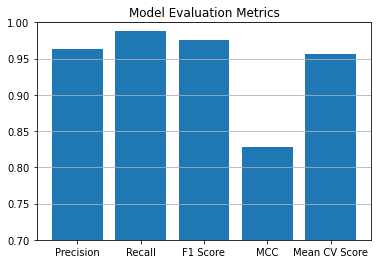

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, df_encoded_classes, test_size=0.33)

imputers = [SimpleImputer]
for 

evaluate_model(SimpleImputer(), StandardScaler(), LogisticRegression(max_iter=10000), X_train, X_test, y_train)

## Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Using a simple imputer TODO use the best
simple_imputer = SimpleImputer(strategy = "median")
df_imputed_simple = simple_imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(df_imputed_simple, y, test_size=0.33)
X_train.shape, X_test.shape

scalers = [(MinMaxScaler(),"MinMaxScaler"), (StandardScaler(),"StandardScaler"), (Normalizer(),"Normalizer"), (PowerTransformer(),"PowerTransformer")]

for scaler,name in scalers:
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='RB')
    recall = recall_score(y_test, y_pred, pos_label='RB')
    cm = confusion_matrix(y_test, y_pred)
    print("Results for:", name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

Results for: MinMaxScaler
Accuracy: 0.9230
Precision: 0.9214
Recall: 0.9920
Confusion Matrix:
[[ 149  106]
 [  10 1242]]

Results for: StandardScaler
Accuracy: 0.9542
Precision: 0.9575
Recall: 0.9888
Confusion Matrix:
[[ 200   55]
 [  14 1238]]

Results for: Normalizer
Accuracy: 0.8719
Precision: 0.8669
Recall: 0.9992
Confusion Matrix:
[[  63  192]
 [   1 1251]]

Results for: PowerTransformer
Accuracy: 0.9396
Precision: 0.9490
Recall: 0.9800
Confusion Matrix:
[[ 189   66]
 [  25 1227]]

